In [1]:
#!/usr/bin/env python3
import sys
import smach
import rospy
import cv2 as cv
import numpy as np
from std_srvs.srv import Empty
from tmc_msgs.msg import Voice
# from geometry_msgs.msg import TransformStamped
import moveit_commander
import moveit_msgs.msg 
# import tf2_ros as tf2
from tf2_sensor_msgs.tf2_sensor_msgs import do_transform_cloud
from utils_takeshi import *
from grasp_utils import *

In [2]:
    global head, whole_body, arm, tfbuff, lis, broad, tf_static_broad
    global rgbd, hand_cam, wrist, gripper, grasp_base, clear_octo_client, service_client, AR_starter, AR_stopper

    moveit_commander.roscpp_initialize(sys.argv)
    rospy.init_node('Pruebas_de_placeo_v2')
    head = moveit_commander.MoveGroupCommander('head')
    whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
    arm =  moveit_commander.MoveGroupCommander('arm')
    
#     tfbuff = tf2.Buffer()
#     lis = tf2.TransformListener(tfbuff)
#     broad = tf2.TransformBroadcaster()
#     tf_static_broad = tf2.StaticTransformBroadcaster()
    
    whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0]) 
    
    rgbd = RGBD()
    hand_cam = HAND_RGB()
    wrist = WRIST_SENSOR()
    gripper = GRIPPER()
    grasp_base = OMNIBASE()
    tf_man = TF_MANAGER()

    clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)
    AR_starter = rospy.ServiceProxy('/marker/start_recognition',Empty)
    AR_stopper = rospy.ServiceProxy('/marker/stop_recognition',Empty)
    
    head.set_planning_time(0.3)
    head.set_num_planning_attempts(1)

[ WARN] [1667508393.203668701]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1667508393.206217836]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1667508393.206257125]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1667508393.206943921]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1667508393.206979280]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1667508403.765535813]: Kinematics solver doesn't support #attempts any

In [8]:
def talk(msg):
    talker = rospy.Publisher('/talk_request', Voice, queue_size=10)
    voice = Voice()
    voice.language = 1
    voice.sentence = msg
    talker.publish(voice)
    

    
def correct_points(low_plane=0.0, high_plane=0.2):

    #Corrects point clouds "perspective" i.e. Reference frame head is changed to reference frame map
    data = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)
    np_data = ros_numpy.numpify(data)
    
#   new implementation to use only tf2
#     transf = tfbuff.lookup_transform('map', 'head_rgbd_sensor_gazebo_frame', rospy.Time())
    
#     [trans, rot] = tf2_obj_2_arr(transf)
    trans, rot = tf_man.getTF(target_frame= 'head_rgbd_sensor_gazebo_frame')
    eu = np.asarray(tf.transformations.euler_from_quaternion(rot))
    t = TransformStamped()
    rot = tf.transformations.quaternion_from_euler(-eu[1], 0, 0)
    t.header.stamp = data.header.stamp
    
    t.transform.rotation.x = rot[0]
    t.transform.rotation.y = rot[1]
    t.transform.rotation.z = rot[2]
    t.transform.rotation.w = rot[3]

    cloud_out = do_transform_cloud(data, t)
    np_corrected = ros_numpy.numpify(cloud_out)
    corrected = np_corrected.reshape(np_data.shape)

    img = np.copy(corrected['y'])

    img[np.isnan(img)] = 2
    #img3 = np.where((img>low)&(img< 0.99*(trans[2])),img,255)
    img3 = np.where((img>0.99*(trans[2])-high_plane)&(img< 0.99*(trans[2])-low_plane),img,255)
    return img3

def plane_seg_square_imgs(lower=500, higher=50000, reg_ly= 30, reg_hy=600, plt_images=True, low_plane=.0, high_plane=0.2):

    #Segment  Plane using corrected point cloud
    #Lower, higher = min, max area of the box
    #reg_ly= 30,reg_hy=600    Region (low y  region high y ) Only centroids within region are accepted
    
    image = rgbd.get_h_image()
    iimmg = rgbd.get_image()
    points_data = rgbd.get_points()
    img = np.copy(image)
    img3 = correct_points(low_plane,high_plane)
    
#     cv2 on python 3
    contours, hierarchy = cv2.findContours(img3.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i = 0
    cents = []
    points = []
    images = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            img = cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                image_aux = iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                images.append(image_aux)
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, f'centroid_{i}_{cX},{cY}',    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz = []

                for jy in range (boundRect[0], boundRect[0] + boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1] + boundRect[3]):
                        aux = (np.asarray((points_data['x'][ix,jy], points_data['y'][ix,jy], points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz = np.asarray(xyz)
                cent = xyz.mean(axis=0)
                cents.append(cent)
#                 print (cent)
                points.append(xyz)
#             else:
#                 print ('cent out of region... rejected')
    sub_plt = 0
    if plt_images:
        for image in images:
           
            sub_plt += 1
            ax = plt.subplot(5, 5, sub_plt)
          
            plt.imshow(image)
            plt.axis("off")

    cents = np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

def seg_square_imgs(lower=2000, higher=50000, reg_ly=0, reg_hy=1000, reg_lx=0, reg_hx=1000, plt_images=True): 

#     Using kmeans for image segmentation find
#     Lower, higher = min, max area of the box
#     reg_ly= 30,reg_hy=600,reg_lx=0,reg_hx=1000, 
#     Region (low  x,y  region high x,y ) Only centroids within region are accepted
    image = rgbd.get_h_image()
    iimmg = rgbd.get_image()
    points_data = rgbd.get_points()
    values = image.reshape((-1,3))
    values = np.float32(values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k = 6
    _ , labels , cc = cv2.kmeans(values, k, None, criteria, 30, cv2.KMEANS_RANDOM_CENTERS)
    cc = np.uint8(cc)
    segmented_image = cc[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    kernel = np.ones((5, 5), np.uint8)
    im4 = cv2.erode(th3, kernel, iterations = 4)
    plane_mask = points_data['z']
    cv2_img = plane_mask.astype('uint8')
    img = im4
    contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i = 0
    cents = []
    points = []
    images = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux = iimmg[boundRect[1]:boundRect[1] + max(boundRect[3],boundRect[2]),boundRect[0]:boundRect[0]+max(boundRect[3],boundRect[2])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            #img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+max(boundRect[2],boundRect[3]), boundRect[1]+max(boundRect[2],boundRect[3])), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy and  cX > reg_lx and cX < reg_hx   ):
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, f'centroid_{i}_{cX},{cY}', (cX - 25, cY - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz = []
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)
                xyz = np.asarray(xyz)
                cent = xyz.mean(axis=0)
                cents.append(cent)
                #print (cent)
                points.append(xyz)
            else:
                #print ('cent out of region... rejected')
                images.pop()
    sub_plt = 0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )
            plt.imshow(image)
            plt.axis("off")
    cents=np.asarray(cents)
    #images.append(img)
    return(cents,np.asarray(points), images)

def static_tf_publish(cents):
#     Publish tfs of the centroids obtained w.r.t. head sensor frame and references them to map (static)
    transf = tfbuff.lookup_transform('map', 'base_link', rospy.Time(0))
    [trans, rot] = tf2_obj_2_arr(transf)
#     closest_centroid_index=  np.argmin(np.linalg.norm(trans-cents, axis=1))##CLOSEST CENTROID
    closest_centroid_index = 0
    min_D_to_base = 10
    for  i, cent  in enumerate(cents):
        x, y, z = cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            t = TransformStamped()
            t.header.stamp = rospy.Time.now()
            t.header.frame_id = "head_rgbd_sensor_link"
            t.child_frame_id = f'Object{i}'
            t.transform.translation.x = x
            t.transform.translation.y = y
            t.transform.translation.z = z
            t.transform.rotation.x = rot[0]
            t.transform.rotation.y = rot[1]
            t.transform.rotation.z = rot[2]
            t.transform.rotation.w = rot[3]
            broad.sendTransform(t)
#             broad.sendTransform((x,y,z), rot, rospy.Time.now(), 'Object'+str(i), "head_rgbd_sensor_link")
            rospy.sleep(0.5)
            transf = tfbuff.lookup_transform('map', f'Object{i}', rospy.Time(0))
            [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
            D_to_base = np.linalg.norm(np.asarray(trans)[:2] - np.asarray(xyz_map)[:2])
            if D_to_base <= min_D_to_base:
                min_D_to_base = D_to_base
                closest_centroid_index = i
                closest_centroid_height = xyz_map[2]
            print ('Distance: base to obj - ', i, np.linalg.norm(np.asarray(trans)[:2] - np.asarray(xyz_map)[:2]))
    i = closest_centroid_index
    transf = tfbuff.lookup_transform('map', f'Object{i}', rospy.Time(0))
    [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
    print('Height closest centroid map', xyz_map[2])
    map_euler = tf.transformations.euler_from_quaternion(cent_quat)
    rospy.sleep(.5)
#     FIXING TF TO MAP ( ODOM REALLY)    
    static_ts = TransformStamped()
    static_ts.header.stamp = rospy.Time.now()
    static_ts.header.frame_id = "map"
    static_ts.child_frame_id = 'cassette'
    static_ts.transform.translation.x = float(xyz_map[0])
    static_ts.transform.translation.y = float(xyz_map[1])
    static_ts.transform.translation.z = float(xyz_map[2])
#     quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
    static_ts.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
    static_ts.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
    static_ts.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
    static_ts.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w
    print ('xyz_map', xyz_map)
    tf_static_broad.sendTransform(static_ts)
    return closest_centroid_height, closest_centroid_index
def publish_point_tf(x,y,z,pointName, ref="map"):
    static_ts = TransformStamped()
    static_ts.header.stamp = rospy.Time.now()
    static_ts.header.frame_id = ref
    static_ts.child_frame_id = f'Point {pointName}'
    static_ts.transform.translation.x = x
    static_ts.transform.translation.y = y
    static_ts.transform.translation.z = z
    static_ts.transform.rotation.x = 0
    static_ts.transform.rotation.y = 0
    static_ts.transform.rotation.z = 0
    static_ts.transform.rotation.w = 1
    tf_static_broad.sendTransform(static_ts)

2
1
2
11
4
Red = square


TypeError: Expected Ptr<cv::UMat> for argument 'image'

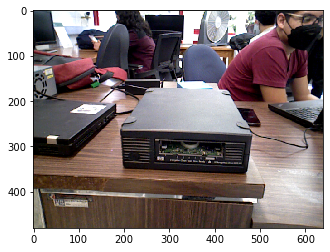

In [38]:
# Shape detection
import matplotlib.pyplot as plt
img = rgbd.get_image()

plt.imshow(img)
# img = np
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

ROI_number = 0
cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    print(len(approx))
    if len(approx)==5:
        print("Blue = pentagon")
        cv.drawContours(img,[cnt],0,255,-1)
    elif len(approx)==3:
        print("Green = triangle")
        cv.drawContours(img,[cnt],0,(0,255,0),-1)
    elif len(approx)==4:
        print("Red = square")
        cv.drawContours(img,[cnt],0,(0,0,255),-1)
    elif len(approx) == 6:
        print("Cyan = Hexa")
        cv.drawContours(img,[cnt],0,(255,255,0),-1)
    elif len(approx) == 8:
        print("White = Octa")
        cv.drawContours(img,[cnt],0,(255,255,255),-1)
    elif len(approx) > 12:
        print("Yellow = circle")
        cv.drawContours(img,[cnt],0,(0,255,255),-1)

cv2.imshow('image', img)
cv2.imshow('Binary',thresh)

In [4]:
rgbd.color_segmentator(color='blue')

[[0.0, 0.0]]

[ WARN] [1665596638.101836859, 187.116000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 187.188000 according to authority /pose_integrator
[ WARN] [1665596638.108287025, 187.116000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 187.188000 according to authority unknown_publisher
[ WARN] [1665596644.558820779, 188.127000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 188.148000 according to authority unknown_publisher
[ WARN] [1665596644.558903988, 188.127000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 188.148000 according to authority /pose_integrator


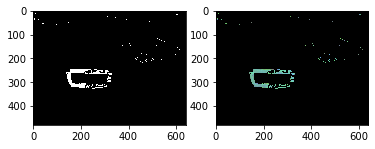

[[238.70561146170903, 267.14668258570697]]

In [10]:
# arm.set_named_target('go')
# arm.go()
# tiny_move_base(x=0.5,std_time=0.3)
hcp= [0,-0.5]
head.set_joint_value_target(hcp)
head.go()
color_segmentator(cam = 'head', color = 'blue',plot=True)
goalPos = [238.7, 267.1]

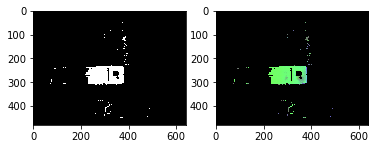

[[301.9245657997062, 268.31642616434806]]

In [3]:
gripper.open()

In [15]:
publish_point_tf(1,-2,2,'Object', ref='map')
# grasp_base.tiny_move(velT=0.5)


In [196]:
place_height=arm.get_current_joint_values()
print(place_height)
altura_optima = 0.1199


[0.11996212191564032, -0.004904528018885301, 0.011163654656305866, -1.5699986302849658, 1.586213108223816, 0.0]


In [23]:
traf = tfbuff.lookup_transform('arm_flex_link', 'Point Object', rospy.Time(0))
trans, rot = tf2_obj_2_arr(traf)
# print(trans,rot)
phi = np.arctan2(trans[1],trans[0])
base_point = np.array((trans[0], trans[1]))
distXY = np.linalg.norm(base_point)
print(phi, distXY)
succ = False
THRESHOLD = 0.02
while not succ:
    traf = tfbuff.lookup_transform('arm_flex_link', 'Point Object', rospy.Time(0))
    trans, rot = tf2_obj_2_arr(traf)
    # print(trans,rot)
    phi = np.arctan2(trans[1],trans[0])
    print(phi)
    if abs(phi)< THRESHOLD:
        succ =True
    else:
        grasp_base.tiny_move(velT = 0.5*phi)

-0.6290689722429843 1.8430254781511024
-0.6290689722429843
-0.5458996357232055
-0.3550002316838438
-0.2112649509194531
-0.11790797476636061
-0.06387548263366954
-0.034876784958602004
-0.01646697987846782


In [21]:
traf = tfbuff.lookup_transform('base_link', 'Point Object', rospy.Time(0))
trans, rot = tf2_obj_2_arr(traf)
# print(trans,rot)
phi = np.arctan2(trans[1],trans[0])
dist = np.sqrt(np.square(trans[0])+np.square(trans[1]))
print(phi, dist)

-1.4962030488427642 2.232888247295115


[ WARN] [1665717270.994381732, 2884.217000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2884.247000 according to authority /pose_integrator
[ WARN] [1665717270.995241433, 2884.217000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2884.247000 according to authority unknown_publisher
[ WARN] [1665717281.936966114, 2885.887000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2885.887000 according to authority /pose_integrator
[ WARN] [1665717281.939711160, 2885.887000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2885.887000 according to authority unknown_publisher


In [5]:
# grasp_base.tiny_move(velT=0.5)
acp= arm.get_current_joint_values()
acp[1] =-0.5
arm.set_joint_value_target(acp)
# arm.set_named_target('neutral')
arm.go()

[ WARN] [1665882665.859643946, 2312.079000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2312.129000 according to authority /pose_integrator
[ WARN] [1665882665.861215799, 2312.079000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2312.129000 according to authority unknown_publisher


True

[ WARN] [1665882691.422585818, 2314.481000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2314.573000 according to authority /pose_integrator
[ WARN] [1665882691.427626157, 2314.481000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2314.573000 according to authority unknown_publisher
[ WARN] [1665882701.060421785, 2315.472000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2315.529000 according to authority /pose_integrator
[ WARN] [1665882701.063515133, 2315.472000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2315.529000 according to authority unknown_publisher
[ WARN] [1665882709.393587006, 2316.612000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2316.642000 according to authority unknown_publisher
[ WARN] [1665882709.395958520, 2316.612000000]: TF_REPEATED_DATA ignoring data with redundant timestam

In [11]:
hcp= [0,0.0]
head.set_joint_value_target(hcp)
head.go()

False

In [13]:
# Calculo de la lambda necesaria para el efector final a partir del arm_roll_link
arm_link = 'arm_flex_link'
# arm_link = 'arm_roll_link'
traf_arl = tfbuff.lookup_transform("base_link",arm_link, rospy.Time(0)) #arm_roll_link
traf_point = tfbuff.lookup_transform("base_link","Point Object", rospy.Time(0))
A, _ = tf2_obj_2_arr(traf_arl) #Vector de posicion ARL
B, _ = tf2_obj_2_arr(traf_point) #Vector de posicion de objeto
# print(trans1,trans2)
A=np.array(A)
B=np.array(B)
V = np.add(-1*A,B) #Vector de direccion AB
# V=V*(1/abs(V))
# print(V)
traf_wrist = tfbuff.lookup_transform(arm_link,"hand_palm_link", rospy.Time(0))
trans3, _ = tf2_obj_2_arr(traf_wrist)
distance=np.linalg.norm(trans3)

V2= [n**2 for n in V]
V2=np.sum(V2)

l1 = distance/np.sqrt(V2)
print(l1)

# print(vector_dir)
posicion = np.add(A,V*1*l1)

print(posicion)
publish_point_tf(posicion[0],posicion[1],posicion[2], 'posicion',ref='base_link')


0.35678527967003004
[ 0.35597752 -0.18270493  0.21869283]


[ WARN] [1665795105.836013329, 3886.441000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3886.452000 according to authority /pose_integrator
[ WARN] [1665795105.837802203, 3886.441000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3886.452000 according to authority unknown_publisher


In [8]:
def point_at(target="Point Object",alpha =0.0):
#     arm.set_named_target('neutral')
#     arm.go()
    arm_f = 'arm_flex_link'
    arm_r= 'arm_roll_link'
    afl = tfbuff.lookup_transform(arm_f,"Point Object", rospy.Time(0)) #arm_roll_link
    arl = tfbuff.lookup_transform(arm_r,"Point Object", rospy.Time(0))
    al = tfbuff.lookup_transform(arm_f,arm_r, rospy.Time(0))
    afl, _ = tf2_obj_2_arr(afl) #Vector de posicion Arm Flex Link (codo)
    arl, _ = tf2_obj_2_arr(arl) #Vector de posicion Arm Roll Link (muñeca)
    al,_ = tf2_obj_2_arr(al) #Medida del brazo
    
    FR=al[2]
    RO= np.sqrt(arl[0]**2+arl[2]**2)
##geometria con 1 angulo
    z = afl[2]
    p = afl[0]
    xi = np.arctan2(p,z)
#     print(xi)
    beta = np.arcsin((-FR*np.sin(alpha+xi))/RO)+alpha+xi
    return alpha,beta   

In [16]:
point_pose=arm.get_current_joint_values()
# point_pose[1]=-alpha
# point_pose[3]=-np.pi+beta
# arm.set_joint_value_target(point_pose)
# arm.set_named_target('neutral')
arm.set_named_target('neutral')
arm.go()
a = 0.2
while(a < 2.61):
    alpha,beta =point_at(alpha=a)
    print(alpha,beta)
    point_pose[1]=-alpha
    point_pose[3]=-beta
    try:
        arm.set_joint_value_target(point_pose)
        succ=arm.go()
        if(succ):
            a=5
    except:
        a+=0.05
        

0.2 0.9471702345397318


In [4]:
arm.set_named_target('neutral')
arm.go()

# arm.set_pose_reference_frame('base_link')
# arm.get_pose_reference_frame()

True

In [21]:
gaze = GAZE()
hcp = gaze.relative(2,1,0)
head.set_joint_value_target(hcp)
head.go()

True

In [38]:
arm.set_named_target('neutral')
arm.go()
# traf1 = tfbuff.lookup_transform('base_link','hand_palm_link', rospy.Time(0))
# _,rot = tf2_obj_2_arr(traf1)
# e = tf.transformations.euler_from_quaternion(rot)
# print(e)
# rot=[0,0,0]
# rot[0] = e[0] + 3.14
# rot[1] = e[1] + 1.57
# rot[2] = e[2]
print(e)
# ori = tf.transformations.quaternion_from_euler(rot[0],rot[1], rot[2])
# arm.set_rpy_target([3.14,0,0])
# arm.go()

[ WARN] [1665772537.230576884, 2743.043000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.090000 according to authority unknown_publisher
[ WARN] [1665772537.233703701, 2743.043000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.090000 according to authority /pose_integrator
[ WARN] [1665772538.172287281, 2743.256000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.294000 according to authority /pose_integrator
[ WARN] [1665772538.172902152, 2743.256000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.294000 according to authority unknown_publisher
[ WARN] [1665772550.443827223, 2745.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2745.550000 according to authority unknown_publisher
[ WARN] [1665772550.456216027, 2745.492000000]: TF_REPEATED_DATA ignoring data with redundant timestam

NameError: name 'e' is not defined

[ WARN] [1665772567.499296082, 2748.552000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2748.552000 according to authority unknown_publisher
[ WARN] [1665772567.518603920, 2748.559000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2748.552000 according to authority /pose_integrator
[ WARN] [1665772582.563667281, 2751.006000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2751.034000 according to authority unknown_publisher
[ WARN] [1665772582.565756860, 2751.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2751.034000 according to authority /pose_integrator
[ WARN] [1665772584.309398714, 2751.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2751.367000 according to authority /pose_integrator
[ WARN] [1665772584.314123028, 2751.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

In [35]:
grasp_base.tiny_move(velX=0.2, MAX_VEL=0.2)

[ WARN] [1666642667.666781709]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642682.532092 according to authority unknown_publisher
[ WARN] [1666642667.666856527]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642682.657493 according to authority unknown_publisher
[ WARN] [1666642667.668593117]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642682.757274 according to authority unknown_publisher
[ WARN] [1666642667.668649980]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642682.807970 according to authority unknown_publisher
[ WARN] [1666642667.668693764]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642682.857862 according to authority unknown_publisher
[ WARN] [1666642667.668727621]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642682.932779 according to authorit

[ WARN] [1666642668.008556123]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642685.235891 according to authority unknown_publisher
[ WARN] [1666642668.008861307]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642685.235891 according to authority /amcl
[ WARN] [1666642668.008966078]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642685.235891 according to authority /amcl
[ WARN] [1666642668.009050327]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642685.235891 according to authority /amcl
[ WARN] [1666642669.255522114]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642685.386288 according to authority unknown_publisher
[ WARN] [1666642669.255626216]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642685.511435 according to authority unknown_publisher
[ WARN] [1666642

[ WARN] [1666642670.867236089]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642686.837619 according to authority /amcl
[ WARN] [1666642670.867340118]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642686.837619 according to authority /amcl
[ WARN] [1666642670.867395112]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642686.837619 according to authority /amcl
[ WARN] [1666642670.867619940]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642686.937933 according to authority /amcl
[ WARN] [1666642670.867673221]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642686.937933 according to authority /amcl
[ WARN] [1666642670.867718735]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642686.937933 according to authority /amcl
[ WARN] [1666642670.867831920]: TF_REPEATED_DATA ign

[ WARN] [1666642680.328677752]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642696.097206 according to authority unknown_publisher
[ WARN] [1666642680.328767003]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642696.147175 according to authority unknown_publisher
[ WARN] [1666642680.328844721]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642696.222341 according to authority unknown_publisher
[ WARN] [1666642680.328907592]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642696.297049 according to authority unknown_publisher
[ WARN] [1666642680.328962601]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642696.397341 according to authority unknown_publisher
[ WARN] [1666642680.335078873]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642696.522441 according to authorit

[ WARN] [1666642681.815073463]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642698.149091 according to authority unknown_publisher
[ WARN] [1666642681.815225447]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642698.373899 according to authority unknown_publisher
[ WARN] [1666642681.815293647]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642698.449195 according to authority unknown_publisher
[ WARN] [1666642681.816452850]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642698.149091 according to authority /amcl
[ WARN] [1666642681.816604049]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642698.149091 according to authority /amcl
[ WARN] [1666642681.816714515]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642698.149091 according to authority /amcl
[ WARN] [1666642

[ WARN] [1666642683.885545098]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642699.550542 according to authority unknown_publisher
[ WARN] [1666642683.885646580]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642699.650412 according to authority unknown_publisher
[ WARN] [1666642683.885715449]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642699.800282 according to authority unknown_publisher
[ WARN] [1666642683.885768867]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642699.900312 according to authority unknown_publisher
[ WARN] [1666642683.885812162]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642700.000818 according to authority unknown_publisher
[ WARN] [1666642683.885849422]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642700.050488 according to authorit

[ WARN] [1666642684.434662803]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642701.302126 according to authority unknown_publisher
[ WARN] [1666642684.435021314]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642701.302126 according to authority /amcl
[ WARN] [1666642684.435088139]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642701.302126 according to authority /amcl
[ WARN] [1666642684.435135443]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642701.302126 according to authority /amcl
[ WARN] [1666642685.443882019]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642701.401750 according to authority /amcl
[ WARN] [1666642685.444003706]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642701.401750 according to authority /amcl
[ WARN] [1666642685.444076382]: TF_REPEA

[ WARN] [1666642689.482442015]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642706.506315 according to authority unknown_publisher
[ WARN] [1666642689.482579442]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642706.706509 according to authority unknown_publisher
[ WARN] [1666642689.483181854]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642706.506315 according to authority /amcl
[ WARN] [1666642689.483258349]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642706.506315 according to authority /amcl
[ WARN] [1666642689.483316174]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642706.506315 according to authority /amcl
[ WARN] [1666642689.483637321]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642706.706509 according to authority /amcl
[ WARN] [1666642689.48368564

[ WARN] [1666642690.702195908]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642707.782434 according to authority unknown_publisher
[ WARN] [1666642690.702357309]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642707.907659 according to authority unknown_publisher
[ WARN] [1666642690.702585308]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642707.782434 according to authority /amcl
[ WARN] [1666642690.702713055]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642707.782434 according to authority /amcl
[ WARN] [1666642690.702800012]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642707.782434 according to authority /amcl
[ WARN] [1666642690.703167372]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642707.907659 according to authority /amcl
[ WARN] [1666642690.70323266

[ WARN] [1666642693.186738597]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642709.433924 according to authority unknown_publisher
[ WARN] [1666642693.187049591]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642709.433924 according to authority /amcl
[ WARN] [1666642693.187128595]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642709.433924 according to authority /amcl
[ WARN] [1666642693.187194845]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642709.433924 according to authority /amcl
[ WARN] [1666642694.191802284]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642709.534366 according to authority unknown_publisher
[ WARN] [1666642694.191900670]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642709.559587 according to authority unknown_publisher
[ WARN] [1666642

[ WARN] [1666642694.565684180]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642711.636170 according to authority unknown_publisher
[ WARN] [1666642694.565748270]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642711.685986 according to authority unknown_publisher
[ WARN] [1666642694.565780456]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642711.761671 according to authority unknown_publisher
[ WARN] [1666642694.565817965]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642711.939675 according to authority unknown_publisher
[ WARN] [1666642694.565841777]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642711.939675 according to authority unknown_publisher
[ WARN] [1666642694.567338788]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642711.636170 according to authorit

[ WARN] [1666642696.003105090]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642713.211958 according to authority unknown_publisher
[ WARN] [1666642696.003169434]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642713.287251 according to authority unknown_publisher
[ WARN] [1666642696.003194266]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642713.287251 according to authority unknown_publisher
[ WARN] [1666642696.003218818]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642713.412351 according to authority unknown_publisher
[ WARN] [1666642696.003244002]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642713.438161 according to authority unknown_publisher
[ WARN] [1666642696.039093032]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642713.211958 according to authorit

[ WARN] [1666642699.594687475]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642715.263471 according to authority /amcl
[ WARN] [1666642699.594769175]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642715.263471 according to authority /amcl
[ WARN] [1666642699.594810680]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642715.263471 according to authority /amcl
[ WARN] [1666642699.594851355]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642715.263471 according to authority /amcl
[ WARN] [1666642699.594888288]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642715.263471 according to authority /amcl
[ WARN] [1666642699.594926285]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642715.263471 according to authority /amcl
[ WARN] [1666642699.595007189]: TF_REPEATED_DATA ign

[ WARN] [1666642701.590306225]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642717.690160 according to authority unknown_publisher
[ WARN] [1666642701.590391120]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642717.790816 according to authority unknown_publisher
[ WARN] [1666642701.590440606]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642717.890768 according to authority unknown_publisher
[ WARN] [1666642701.590489862]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642718.065743 according to authority unknown_publisher
[ WARN] [1666642701.590530946]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642718.140528 according to authority unknown_publisher
[ WARN] [1666642701.590561291]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642718.140528 according to authorit

[ WARN] [1666642702.841424858]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642719.692040 according to authority unknown_publisher
[ WARN] [1666642702.841497720]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642719.741992 according to authority unknown_publisher
[ WARN] [1666642702.841538122]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642719.817181 according to authority unknown_publisher
[ WARN] [1666642702.841580297]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642719.992419 according to authority unknown_publisher
[ WARN] [1666642702.842016076]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642719.692040 according to authority /amcl
[ WARN] [1666642702.842175876]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642719.692040 according to authority /amcl
[ WA

[ WARN] [1666642704.777440782]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642720.892949 according to authority unknown_publisher
[ WARN] [1666642704.777511308]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642720.968293 according to authority unknown_publisher
[ WARN] [1666642704.777544837]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642720.993037 according to authority unknown_publisher
[ WARN] [1666642704.777587230]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642721.142935 according to authority unknown_publisher
[ WARN] [1666642704.777622471]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642721.268052 according to authority unknown_publisher
[ WARN] [1666642704.777662573]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642721.418527 according to authorit

[ WARN] [1666642705.327663612]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642722.419322 according to authority unknown_publisher
[ WARN] [1666642705.327828195]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642722.419322 according to authority /amcl
[ WARN] [1666642705.327922916]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642722.419322 according to authority /amcl
[ WARN] [1666642705.327986082]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642722.419322 according to authority /amcl
[ WARN] [1666642705.916682200]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642722.620650 according to authority unknown_publisher
[ WARN] [1666642705.916752357]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642722.694776 according to authority unknown_publisher
[ WARN] [1666642

[ WARN] [1666642719.742647542]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642732.878881 according to authority unknown_publisher
[ WARN] [1666642719.742721964]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642732.954682 according to authority unknown_publisher
[ WARN] [1666642719.742756357]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642732.954682 according to authority unknown_publisher
[ WARN] [1666642719.742794147]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642733.003876 according to authority unknown_publisher
[ WARN] [1666642719.742832339]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642733.154103 according to authority unknown_publisher
[ WARN] [1666642719.742864795]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642733.253853 according to authorit

[ WARN] [1666642720.663776934]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642734.530180 according to authority unknown_publisher
[ WARN] [1666642720.663851956]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642734.605050 according to authority unknown_publisher
[ WARN] [1666642720.663894485]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642734.655346 according to authority unknown_publisher
[ WARN] [1666642720.663935383]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642734.780196 according to authority unknown_publisher
[ WARN] [1666642720.663964495]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642734.805265 according to authority unknown_publisher
[ WARN] [1666642720.663995375]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642734.855476 according to authorit

[ WARN] [1666642721.596064718]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642735.731345 according to authority unknown_publisher
[ WARN] [1666642721.596278240]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642735.731345 according to authority /amcl
[ WARN] [1666642721.596362990]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642735.731345 according to authority /amcl
[ WARN] [1666642721.596441922]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642735.731345 according to authority /amcl
[ WARN] [1666642723.356780654]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642735.956558 according to authority /amcl
[ WARN] [1666642723.356857096]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642735.956558 according to authority /amcl
[ WARN] [1666642723.356905033]: TF_REPEA

[ WARN] [1666642725.864346084]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642740.735473 according to authority unknown_publisher
[ WARN] [1666642725.864422507]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642740.785428 according to authority unknown_publisher
[ WARN] [1666642725.864468768]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642740.785428 according to authority unknown_publisher
[ WARN] [1666642725.864514381]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642740.935380 according to authority unknown_publisher
[ WARN] [1666642725.864566517]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642740.985648 according to authority unknown_publisher
[ WARN] [1666642725.864607294]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642741.010869 according to authorit

[ WARN] [1666642733.907632415]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642750.218672 according to authority unknown_publisher
[ WARN] [1666642733.907759264]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642750.368899 according to authority unknown_publisher
[ WARN] [1666642733.907846879]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642750.518907 according to authority unknown_publisher
[ WARN] [1666642733.907904416]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642750.544119 according to authority unknown_publisher
[ WARN] [1666642733.907954923]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642750.544119 according to authority unknown_publisher
[ WARN] [1666642733.908010032]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642750.669211 according to authorit

[ WARN] [1666642735.972359032]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642751.869863 according to authority unknown_publisher
[ WARN] [1666642735.972473122]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642751.869863 according to authority unknown_publisher
[ WARN] [1666642735.972986492]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642752.170552 according to authority unknown_publisher
[ WARN] [1666642735.973192034]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642752.295780 according to authority unknown_publisher
[ WARN] [1666642735.973361814]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642752.370535 according to authority unknown_publisher
[ WARN] [1666642735.973497832]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642752.370535 according to authorit

[ WARN] [1666642738.134174856]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642753.021126 according to authority unknown_publisher
[ WARN] [1666642738.134232128]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642753.071388 according to authority unknown_publisher
[ WARN] [1666642738.134273402]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642753.171077 according to authority unknown_publisher
[ WARN] [1666642738.134310920]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642753.246436 according to authority unknown_publisher
[ WARN] [1666642738.134380184]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642753.346351 according to authority unknown_publisher
[ WARN] [1666642738.143909149]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642753.021126 according to authorit

[ WARN] [1666642738.479778043]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642754.672548 according to authority unknown_publisher
[ WARN] [1666642738.479927289]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642754.772622 according to authority unknown_publisher
[ WARN] [1666642738.480008644]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642754.772622 according to authority unknown_publisher
[ WARN] [1666642738.480117591]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642754.897698 according to authority unknown_publisher
[ WARN] [1666642738.480194880]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642754.922315 according to authority unknown_publisher
[ WARN] [1666642738.480265336]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642755.022871 according to authorit

[ WARN] [1666642740.841061755]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642756.874349 according to authority unknown_publisher
[ WARN] [1666642740.841117079]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642756.899109 according to authority unknown_publisher
[ WARN] [1666642740.841148938]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642756.999587 according to authority unknown_publisher
[ WARN] [1666642740.841179385]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642757.049288 according to authority unknown_publisher
[ WARN] [1666642740.841206460]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642757.149259 according to authority unknown_publisher
[ WARN] [1666642740.841519996]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642756.874349 according to authorit

[ WARN] [1666642752.266467898]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642768.407449 according to authority unknown_publisher
[ WARN] [1666642752.266598015]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642768.532917 according to authority unknown_publisher
[ WARN] [1666642752.266688315]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642768.608084 according to authority unknown_publisher
[ WARN] [1666642752.266747120]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642768.683161 according to authority unknown_publisher
[ WARN] [1666642752.266806433]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642768.757930 according to authority unknown_publisher
[ WARN] [1666642752.269550917]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642768.407449 according to authorit

[ WARN] [1666642753.664080936]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642769.833852 according to authority unknown_publisher
[ WARN] [1666642753.664262943]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642769.833852 according to authority /amcl
[ WARN] [1666642753.664393800]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642769.833852 according to authority /amcl
[ WARN] [1666642753.664499620]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642769.833852 according to authority /amcl
[ WARN] [1666642753.667095938]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642769.833852 according to authority unknown_publisher
[ WARN] [1666642753.667233750]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642770.183886 according to authority unknown_publisher
[ WARN] [1666642

[ WARN] [1666642754.188782179]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642771.709734 according to authority unknown_publisher
[ WARN] [1666642754.188837517]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642771.759561 according to authority unknown_publisher
[ WARN] [1666642754.190281857]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642771.709734 according to authority /amcl
[ WARN] [1666642754.190350927]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642771.709734 according to authority /amcl
[ WARN] [1666642754.190394036]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642771.709734 according to authority /amcl
[ WARN] [1666642754.190492061]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642771.759561 according to authority /amcl
[ WARN] [1666642754.19054573

[ WARN] [1666642760.010155854]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642776.737789 according to authority unknown_publisher
[ WARN] [1666642760.010471984]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642776.737789 according to authority /amcl
[ WARN] [1666642760.010535044]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642776.737789 according to authority /amcl
[ WARN] [1666642760.010592625]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642776.737789 according to authority /amcl
[ WARN] [1666642760.464697418]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642776.863001 according to authority unknown_publisher
[ WARN] [1666642760.464760320]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642776.938225 according to authority unknown_publisher
[ WARN] [1666642

[ WARN] [1666642761.889102808]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642778.213795 according to authority unknown_publisher
[ WARN] [1666642761.889239330]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642778.413924 according to authority unknown_publisher
[ WARN] [1666642761.890672670]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642778.213795 according to authority /amcl
[ WARN] [1666642761.890751841]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642778.213795 according to authority /amcl
[ WARN] [1666642761.890787264]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642778.213795 according to authority /amcl
[ WARN] [1666642761.890940376]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642778.413924 according to authority /amcl
[ WARN] [1666642761.89097367

[ WARN] [1666642763.572056246]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642780.640979 according to authority unknown_publisher
[ WARN] [1666642763.572127257]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642780.640979 according to authority unknown_publisher
[ WARN] [1666642763.572169153]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642780.765581 according to authority unknown_publisher
[ WARN] [1666642763.572206783]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642780.841103 according to authority unknown_publisher
[ WARN] [1666642763.572248472]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642780.965941 according to authority unknown_publisher
[ WARN] [1666642763.578843226]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642780.640979 according to authorit

[ WARN] [1666642768.775261932]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642785.369536 according to authority /amcl
[ WARN] [1666642768.775353160]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642785.369536 according to authority /amcl
[ WARN] [1666642768.775406185]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642785.369536 according to authority /amcl
[ WARN] [1666642768.775508592]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642785.444706 according to authority /amcl
[ WARN] [1666642768.775561472]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642785.444706 according to authority /amcl
[ WARN] [1666642768.775608120]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642785.444706 according to authority /amcl
[ WARN] [1666642768.775753826]: TF_REPEATED_DATA ign

[ WARN] [1666642770.777874073]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642786.545599 according to authority unknown_publisher
[ WARN] [1666642770.777955966]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642786.595889 according to authority unknown_publisher
[ WARN] [1666642770.777998111]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642786.720876 according to authority unknown_publisher
[ WARN] [1666642770.778291674]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642786.545599 according to authority /amcl
[ WARN] [1666642770.778364331]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642786.545599 according to authority /amcl
[ WARN] [1666642770.778413054]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642786.545599 according to authority /amcl
[ WARN] [1666642

[ WARN] [1666642772.384319882]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642788.922908 according to authority unknown_publisher
[ WARN] [1666642772.384491126]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642788.948098 according to authority unknown_publisher
[ WARN] [1666642772.384611014]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642789.048735 according to authority unknown_publisher
[ WARN] [1666642772.384746221]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642789.122703 according to authority unknown_publisher
[ WARN] [1666642772.384853099]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642789.197860 according to authority unknown_publisher
[ WARN] [1666642772.384959730]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642788.922908 according to authorit

[ WARN] [1666642777.971211204]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642792.727071 according to authority /amcl
[ WARN] [1666642777.971383309]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642792.727071 according to authority /amcl
[ WARN] [1666642777.971499965]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642792.727071 according to authority /amcl
[ WARN] [1666642777.971606248]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642792.727071 according to authority /amcl
[ WARN] [1666642777.971702189]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642792.727071 according to authority /amcl
[ WARN] [1666642777.971790165]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642792.727071 according to authority /amcl
[ WARN] [1666642777.971993795]: TF_REPEATED_DATA ign

[ WARN] [1666642781.505423975]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642798.156016 according to authority unknown_publisher
[ WARN] [1666642781.505565619]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642798.256004 according to authority unknown_publisher
[ WARN] [1666642781.505698163]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642798.156016 according to authority /amcl
[ WARN] [1666642781.505777491]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642798.156016 according to authority /amcl
[ WARN] [1666642781.505834751]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642798.156016 according to authority /amcl
[ WARN] [1666642781.505987888]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642798.256004 according to authority /amcl
[ WARN] [1666642781.50603304

[ WARN] [1666642789.379739901]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642805.587604 according to authority unknown_publisher
[ WARN] [1666642789.379787913]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642805.587604 according to authority unknown_publisher
[ WARN] [1666642789.379818895]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642805.737247 according to authority unknown_publisher
[ WARN] [1666642789.379845782]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642805.837863 according to authority unknown_publisher
[ WARN] [1666642789.383423701]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642805.587604 according to authority /amcl
[ WARN] [1666642789.383499658]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642805.587604 according to authority /amcl
[ WA

[ WARN] [1666642793.544965739]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642808.841189 according to authority /amcl
[ WARN] [1666642793.545157879]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642808.841189 according to authority /amcl
[ WARN] [1666642793.545254126]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642808.841189 according to authority /amcl
[ WARN] [1666642793.545654340]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642809.015203 according to authority /amcl
[ WARN] [1666642793.545710297]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642809.015203 according to authority /amcl
[ WARN] [1666642793.545756914]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642809.015203 according to authority /amcl
[ WARN] [1666642793.545909134]: TF_REPEATED_DATA ign

[ WARN] [1666642796.243379257]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642810.966864 according to authority unknown_publisher
[ WARN] [1666642796.243439933]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642811.016194 according to authority unknown_publisher
[ WARN] [1666642796.243471109]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642811.041250 according to authority unknown_publisher
[ WARN] [1666642796.243497672]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642811.091635 according to authority unknown_publisher
[ WARN] [1666642796.243521801]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642811.166513 according to authority unknown_publisher
[ WARN] [1666642796.243547839]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642811.241377 according to authorit

[ WARN] [1666642796.456933744]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642812.567482 according to authority unknown_publisher
[ WARN] [1666642796.456991094]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642812.617297 according to authority unknown_publisher
[ WARN] [1666642796.457022509]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642812.792747 according to authority unknown_publisher
[ WARN] [1666642796.457411675]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642812.567482 according to authority /amcl
[ WARN] [1666642796.457475717]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642812.567482 according to authority /amcl
[ WARN] [1666642796.457524637]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642812.567482 according to authority /amcl
[ WARN] [1666642

[ WARN] [1666642800.496752922]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642815.369549 according to authority unknown_publisher
[ WARN] [1666642800.497312466]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642815.394318 according to authority unknown_publisher
[ WARN] [1666642800.497348501]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642815.444298 according to authority unknown_publisher
[ WARN] [1666642800.498033078]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642815.369549 according to authority /amcl
[ WARN] [1666642800.498093296]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642815.369549 according to authority /amcl
[ WARN] [1666642800.498144934]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642815.369549 according to authority /amcl
[ WARN] [1666642

[ WARN] [1666642804.051767569]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642819.796638 according to authority unknown_publisher
[ WARN] [1666642804.051859937]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642819.871471 according to authority unknown_publisher
[ WARN] [1666642804.052072477]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642820.046938 according to authority unknown_publisher
[ WARN] [1666642804.052560579]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642819.796638 according to authority /amcl
[ WARN] [1666642804.052633256]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642819.796638 according to authority /amcl
[ WARN] [1666642804.052689659]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642819.796638 according to authority /amcl
[ WARN] [1666642

[ WARN] [1666642805.484322812]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642822.673595 according to authority unknown_publisher
[ WARN] [1666642805.484391289]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642822.823307 according to authority unknown_publisher
[ WARN] [1666642805.484790872]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642822.673595 according to authority /amcl
[ WARN] [1666642805.484848046]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642822.673595 according to authority /amcl
[ WARN] [1666642805.484894655]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642822.673595 according to authority /amcl
[ WARN] [1666642805.485096977]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 1666642822.823307 according to authority /amcl
[ WARN] [1666642805.48514359

In [34]:
succ = False
THRESHOLD = 0.05
phi = np.arctan(trans[1]/trans[0])
while not succ:
    traf = tfbuff.lookup_transform("arm_flex_link","cassette", rospy.Time(0))
    # print(traf)
    trans, rot = tf2_obj_2_arr(traf)
    rot = tf.transformations.euler_from_quaternion(rot)
    alpha = rot[2]
    xi = alpha - phi
    grasp_base.tiny_move(velT=xi)
    print(xi)
    if abs(xi) < THRESHOLD:
        succ = True

0.8042043844640404


[ WARN] [1665623172.079860945, 430.524000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 430.545000 according to authority unknown_publisher
[ WARN] [1665623172.107544968, 430.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 430.545000 according to authority /pose_integrator


0.9627343380237757


[ WARN] [1665623178.398525695, 431.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.346000 according to authority /pose_integrator
[ WARN] [1665623178.401029254, 431.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.346000 according to authority unknown_publisher


1.227817450702567


[ WARN] [1665623181.641059997, 431.661000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.697000 according to authority unknown_publisher
[ WARN] [1665623181.641936006, 431.661000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.697000 according to authority /pose_integrator


1.474250966833053


[ WARN] [1665623186.121919611, 432.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 432.429000 according to authority unknown_publisher
[ WARN] [1665623186.134344189, 432.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 432.429000 according to authority /pose_integrator


1.7304860238569821
1.9436754175419153


[ WARN] [1665623195.792203083, 433.569000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 433.590000 according to authority unknown_publisher
[ WARN] [1665623195.794491022, 433.569000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 433.590000 according to authority /pose_integrator


2.1881240948556053
2.419387873087577


[ WARN] [1665623200.528027022, 434.259000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 434.304000 according to authority /pose_integrator
[ WARN] [1665623200.529587045, 434.259000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 434.304000 according to authority unknown_publisher


2.6639739419958235
2.934356938426432
3.1574973029198388


[ WARN] [1665623212.893324530, 435.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 436.023000 according to authority unknown_publisher
[ WARN] [1665623212.895272347, 435.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 436.023000 according to authority /pose_integrator


3.408525729593331
3.6601616117578124
3.8935089946995727
4.134903790481864
4.41233921939955


[ WARN] [1665623234.706972788, 438.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 438.411000 according to authority unknown_publisher
[ WARN] [1665623234.709088697, 438.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 438.411000 according to authority /pose_integrator


4.664969414303059
-1.3540786659722648


[ WARN] [1665623245.578816394, 439.650000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.668000 according to authority unknown_publisher
[ WARN] [1665623245.579854765, 439.650000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.668000 according to authority /pose_integrator


-1.5624566796020911


[ WARN] [1665623246.886324475, 439.773000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.836000 according to authority /pose_integrator
[ WARN] [1665623246.888148309, 439.773000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.836000 according to authority unknown_publisher
[ WARN] [1665623248.604699516, 440.025000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.025000 according to authority unknown_publisher
[ WARN] [1665623248.626293776, 440.025000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.025000 according to authority /pose_integrator


4.487474235895136
4.667659309994933


[ WARN] [1665623255.312984239, 440.703000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.787000 according to authority unknown_publisher
[ WARN] [1665623255.331032218, 440.787000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.787000 according to authority /pose_integrator
[ WARN] [1665623258.029371676, 441.060000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.096000 according to authority unknown_publisher
[ WARN] [1665623258.039671915, 441.060000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.096000 according to authority /pose_integrator


-1.3638119986572717


[ WARN] [1665623264.167902253, 441.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.756000 according to authority /pose_integrator
[ WARN] [1665623264.176762968, 441.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.756000 according to authority unknown_publisher


-1.4151915529706867


[ WARN] [1665623265.497318535, 441.873000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.903000 according to authority unknown_publisher
[ WARN] [1665623265.506412748, 441.873000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.903000 according to authority /pose_integrator
[ WARN] [1665623267.878054307, 442.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.140000 according to authority /pose_integrator
[ WARN] [1665623267.880019822, 442.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.140000 according to authority unknown_publisher


4.615697600946868


[ WARN] [1665623270.285622313, 442.383000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.422000 according to authority /pose_integrator
[ WARN] [1665623270.292976313, 442.383000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.422000 according to authority unknown_publisher
[ WARN] [1665623271.999579018, 442.599000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.626000 according to authority unknown_publisher
[ WARN] [1665623272.001248232, 442.599000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.626000 according to authority /pose_integrator


-1.5802119505662389
4.6589315749711115
-1.4430394984445338


[ WARN] [1665623283.838331838, 444.258000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.303000 according to authority /pose_integrator
[ WARN] [1665623283.840466262, 444.258000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.303000 according to authority unknown_publisher
[ WARN] [1665623285.206781637, 444.369000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.414000 according to authority unknown_publisher
[ WARN] [1665623285.215603913, 444.369000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.414000 according to authority /pose_integrator


-1.5959959081960315
4.402760262146424


[ WARN] [1665623290.656490580, 445.008000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 445.035000 according to authority /pose_integrator
[ WARN] [1665623290.659464316, 445.008000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 445.035000 according to authority unknown_publisher


KeyboardInterrupt: 

In [13]:
publish_point_tf(1,0,0,'Brazo1',ref='head_rgbd_sensor_gazebo_frame')
traf = tfbuff.lookup_transform('map','Point Brazo1', rospy.Time(0))
trans,_ = tf2_obj_2_arr(traf)
publish_point_tf(trans[0],trans[1],trans[2],'Brazo2',ref='map')


In [4]:
gripper.steady()

In [24]:
traf = tfbuff.lookup_transform('base_link','ar_marker/201',rospy.Time(0))
tf2_obj_2_arr(traf)

[[0.6874551323475802, -0.07794949487462331, 0.6920933666831193],
 [0.38622610890625253,
  -0.9132626640126938,
  0.11953214690258941,
  -0.04992759934576225]]

shutdown request: [/Pruebas_de_placeo_v2] Reason: new node registered with same name


In [46]:
# gaze = GAZE()
# rospy.sleep(0.3)
hcp = gaze.relative(1,0,1.5)

In [47]:
head.set_joint_value_target(hcp)
head.go()

True

In [50]:
grasp_from_above_joints = [0.5 - 0.102,-1.3376,0,-1.8275,0.0,0.0]
arm.set_joint_value_target(grasp_from_above_joints)
arm.go()

True

In [9]:
head.set_joint_value_target(hcp)
plan1=head.plan()
print(plan1)

(True, joint_trajectory: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: "odom"
  joint_names: 
    - head_pan_joint
    - head_tilt_joint
  points: 
    - 
      positions: [9.845300397159917e-08, 3.072710080154195e-06]
      velocities: [0.0, 0.0]
      accelerations: [-0.25954155325261236, 0.0]
      effort: []
      time_from_start: 
        secs: 0
        nsecs:         0
    - 
      positions: [-0.3082357080967697, -0.02672683923475751]
      velocities: [-0.2, -0.017343807161171808]
      accelerations: [0.0, 0.0]
      effort: []
      time_from_start: 
        secs: 1
        nsecs: 541179033
    - 
      positions: [-0.6164715146465434, -0.053456751179595176]
      velocities: [-0.2, -0.01734380716117181]
      accelerations: [0.0, -4.502328254187915e-18]
      effort: []
      time_from_start: 
        secs: 3
        nsecs:  82358065
    - 
      positions: [-0.9247073211963168, -0.08018666312443283]
      velocities: [-0.2, -0.017343

In [4]:
head.go()

True

In [3]:
tf_man.pub_tf(pos=[0,0,1],point_name="Prueba")

[ WARN] [1666711851.482723308, 2372.108000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2372.140000 according to authority /pose_integrator


In [4]:
tf_man.pub_static_tf(pos=[1,1,0], point_name="Prueba2", ref="base_link")

In [5]:
tf_man.getTF(target_frame="Prueba2", ref_frame="hand_palm_link")

[[-0.8421139494487837, -0.921969024690146, -0.8253554575107672],
 [8.409011763498917e-05,
  -6.667201995350538e-10,
  0.9999999963000041,
  1.8134050913944013e-05]]

In [7]:
tf_man.change_ref_frame_tf(point_name="Prueba2", new_frame="hand_palm_link")

True

[ WARN] [1666711874.620840322, 2375.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2375.913000 according to authority /pose_integrator
[ WARN] [1666711889.885061539, 2378.228000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2378.244000 according to authority /pose_integrator
[ WARN] [1666711898.451992145, 2379.610000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2379.639000 according to authority /pose_integrator
[ WARN] [1666711913.756545555, 2382.235000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2382.294000 according to authority /pose_integrator
[ WARN] [1666711919.850162034, 2383.273000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2383.273000 according to authority /pose_integrator
[ WARN] [1666711946.132234740, 2387.564000000]: TF_REPEATED_DATA ignoring data with redundant timestamp f

In [8]:
succ = False
pos_init, _ = tf_man.getTF(target_frame='hand_l_finger_tip_frame', ref_frame='base_link')
print(trans)
while not succ:
    
    print(wrist.get_force())
    rospy.sleep(1)
    succ = True

[0.3806347696453725, 0.07500983760693127, 0.8067079942867146]
[0.0, 0.0, 0.0]


In [20]:
arm.shift_pose_target(1,0.02)
plan=arm.plan()
print(plan)

(False, joint_trajectory: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  joint_names: []
  points: []
multi_dof_joint_trajectory: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  joint_names: []
  points: [], 6.9429969200279e-310, val: -1)


[ WARN] [1666810669.483538867]: Fail: ABORTED: No motion plan found. No execution attempted.


In [19]:
arm.go()

False

In [24]:
pose = arm.get_current_pose()
print(pose)
pose.pose.position.x -= 0.2
arm.set_pose_target(pose)
arm.go()

header: 
  seq: 0
  stamp: 
    secs: 1666810870
    nsecs: 915765762
  frame_id: "odom"
pose: 
  position: 
    x: -0.18999941133999118
    y: 1.2468060162826906
    z: 0.804505092811182
  orientation: 
    x: -0.7019205615122638
    y: 0.08515711287507609
    z: -0.09992744084494107
    w: 0.7000502110700851


False

In [25]:
arm.set_pose_reference_frame('base_link')

In [42]:
arm.get_current_pose()

header: 
  seq: 0
  stamp: 
    secs: 1666812230
    nsecs: 267655372
  frame_id: "odom"
pose: 
  position: 
    x: -0.39494737924461376
    y: 1.1805313323053215
    z: 0.6786480991839785
  orientation: 
    x: -0.5913247836715109
    y: -0.40588294987165713
    z: -0.5770024718473402
    w: 0.3907200771669943

In [45]:
tf_man.getTF(target_frame='arm_roll_link', ref_frame='odom')

[[-0.44581117260569963, 1.0532282612580477, 0.6946909559154535],
 [-0.010813641518271444,
  0.010549517800297186,
  0.5628055233688127,
  0.8264512784773539]]

In [50]:
whole_body.shift_pose_target(1,0.02)
whole_body.go()

True

In [3]:
gripper.steady()

NameError: name 'gripper' is not defined

In [47]:
gripper.close()

In [ ]:
arm.set_named_target('go')
arm.go()

In [ ]:
head.set_named_target('neutral')
head.go()

In [10]:
grasp_base.tiny_move(velT=-1, MAX_VEL=.6)

In [3]:
trans, rot=tf_man.getTF(target_frame='cassette', ref_frame='odom')
trans[2] += 0.2
whole_body.set_position_target(trans)
plan1= whole_body.plan()
print(plan1)

TypeError: 'bool' object is not subscriptable

In [94]:
class HAND_RGB():
    def __init__(self):
        self.cam_sub = rospy.Subscriber(
            '/hsrb/hand_camera/image_raw',
            ImageMsg, self._callback)
        self._points_data = None
        self._image_data = None
        
    def _callback(self, msg):
        self._image_data = ros_numpy.numpify(msg)
        
    def get_image(self):
        image = self._image_data
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
#Color segmentator
    def color_segmentator(self, color = "orange"):
        image = self.get_image()
        if(color == "blue"):
            lower_threshold = (100,120,100)
            upper_threshold = (150,220,240)
        else:
            lower_threshold = (105,130,100)
            upper_threshold = (115,225,255)
        img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(img_hsv, lower_threshold, upper_threshold)
        res = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
        pos = []
        pixels = cv2.findNonZero(mask)
        pixels = list(cv2.mean(pixels))
        pos.append(pixels[:2])
        return pos, mask

In [95]:
hand = HAND_RGB()

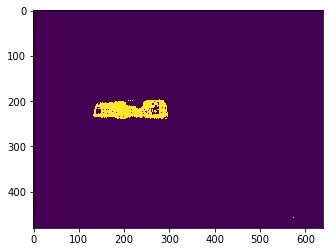

In [99]:
import matplotlib.pyplot as plt
pos, img = hand.color_segmentator()
plt.imshow(img)

In [100]:
print(pos)

[[215.91684078562474, 219.87442540743837]]


In [111]:
        succ = False
        X_THRESHOLD = 20
        Y_THRESHOLD = 10
        goalPos = [258.61,261.75]
        while not succ:
            [currentPos] = hand_cam.color_segmentator(color = 'orange')
#     print(currentPos)
            ex = -(goalPos[0]-currentPos[0]) 
            ey = (goalPos[1]-currentPos[1])
            print(ex, ey)
            if abs(ex) > X_THRESHOLD:
                grasp_base.tiny_move(velX = 0.001*ex, std_time=0.05, MAX_VEL=0.02)#, y = -traf.y + Y_OFFSET)
                rospy.sleep(0.5)
            if abs(ey) > Y_THRESHOLD:
                grasp_base.tiny_move(velY = 0.001*ey, std_time=0.05, MAX_VEL=0.02)
                rospy.sleep(0.5)
            if (abs(ex) <= X_THRESHOLD and abs(ey) <= Y_THRESHOLD):
#                 talk("done, now i will take it")
                succ = True
#             rospy.sleep(1)

-2.955652532585418 30.26031182973108
-2.7278895300906925 29.964179719703196
-1.5762325132658361 28.954695288631626
-3.227608624632495 30.93098660568444
-5.553298969072188 11.896423969072174
-4.294817311103259 -4.99689606243345


[ERROR] [1667501306.427624748]: Ignoring transform for child_frame_id "codoD" from authority "unknown_publisher" because of a nan value in the transform (nan nan nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1667501306.429607345]: Ignoring transform for child_frame_id "codoD" from authority "/recognize_action_server" because of a nan value in the transform (nan nan nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1667501306.445850201]: Ignoring transform for child_frame_id "codoI" from authority "unknown_publisher" because of a nan value in the transform (nan nan nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1667501306.445986183]: Ignoring transform for child_frame_id "codoI" from authority "/recognize_action_server" because of a nan value in the transform (nan nan nan) (0.000000 0.000000 0.000000 1.000000)
[ERROR] [1667501728.581721954]: Ignoring transform for child_frame_id "manoI" from authority "unknown_publisher" because of a nan value in the transform (nan nan nan)

In [ ]:
_, rot = tf_man.getTF(target_frame='base_link', ref_frame='map')
theta = rot[2]
print(theta)
vel = 0.3
succ = False
diff=0.0
while abs(diff) < 1:
    _, rot = tf_man.getTF(target_frame='base_link')
    alpha = rot[2]
    diff = theta - alpha
    print(diff)
    grasp_base.tiny_move(velT=-vel, std_time=0.3)
while abs(diff) < 1 :
    _, rot = tf_man.getTF(target_frame='base_link')
    alpha = rot[2]
    diff = theta - alpha
    print(diff)
    grasp_base.tiny_move(velT=-1*vel, std_time=0.3)


In [4]:
arm.get_current_joint_values()

[0.6808364143410864,
 -1.1653615280188854,
 -0.011304345343694067,
 -1.9200046302849658,
 -0.028681891776184187,
 0.0]

In [5]:
gripper.steady()

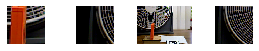

In [14]:
cents, points, images = plane_seg_square_imgs(low_plane=0.8, high_plane=1.0)

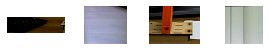

In [20]:
cents, point, images = seg_square_imgs()

In [21]:
print(cents)

[[-0.2705867   0.26329783  0.66050696]
 [ 0.35316342  0.2896841   0.78458184]
 [-0.06169942  0.23005404  0.67817384]
 [ 0.4157102  -0.50240695  1.365338  ]]


In [25]:
tf_man.pub_tf(pos = cents[0], point_name='prueba', ref='map')